# Benchmarking a method

When developing a new method, you might want to see how other methods perform
on the dataset you are evaluating. Photoholmes includes the implementation for several
methods from the literature, covering a diverse array of approaches to forgery detection
to compare to.

It also includes a Benchmark object to easily evaluate the performance of a method over
a dataset. This ensures a fair and reproducible comparison between methods.
This notebook is a short tutorial on how to use Benchmark object, using as an example 
the included method DQ and a custom method we will define on the Columbia dataset.

1. [ Running an included method ](#running-an-included-method)
2. [ Running a custom method ](#running-a-custom-method)


## Running an included method


### Method selection

To run an included method, we first import and instantiate the method. You can do this by using the **method factory**.


In [2]:
from photoholmes.methods.factory import MethodFactory, MethodRegistry


dq, dq_preprocessing = MethodFactory.load(MethodRegistry.DQ)

Or by **importing** the method **directly**. In this case, it's important to also import the corresponding **preprocessing** pipeline, as it is a required argument for the Dataset. 


In [13]:
from photoholmes.methods.dq import DQ, dq_preprocessing

dq = DQ()
dq

### Loading a Dataset for evaluation

To continue, we must first download the [Columbia Uncompressed Image Splicing Detection](https://www.ee.columbia.edu/ln/dvmm/downloads/authsplcuncmp/) dataset. Keep in mind this dataset is under a [ research-only use License ](https://www.ee.columbia.edu/ln/dvmm/downloads/authsplcuncmp/dlform.html). You can download the dataset [ here ](https://www.dropbox.com/sh/786qv3yhvc7s9ki/AACbEEzGPrD3_y38bpWHzgdqa?e=1&dl=0).

Once downloaded, unzip the files and update the following variable with the path to the dataset folder.


In [9]:
columbia_dataset_path: str = (
    "data/Columbia Uncompressed Image Splicing Detection"  # UPDATE WITH THE PATH ON YOUR COMPUTER
)

As well as with the methods, we can load a dataset by **direct import**:


In [10]:
from photoholmes.datasets.columbia import ColumbiaDataset

dataset = ColumbiaDataset(
    img_dir=columbia_dataset_path,
    item_data=["image", "dct_coefficients", "qtables"],
    transform=dq_preprocessing,
)
print("Total images: ", len(dataset))

Total images:  363


Or using the **factory**


In [11]:
from photoholmes.datasets.dataset_factory import DatasetFactory, DatasetName


dataset = DatasetFactory.load(
    DatasetName.COLUMBIA,
    dataset_dir=columbia_dataset_path,
    item_data=["image", "dct_coefficients", "qtables"],
    transform=dq_preprocessing,
)
print("Total images: ", len(dataset))

Total images:  363


%% FIXME add links y referencias a nuestra propia documentación cuando este

For more information on the datasets, see the Datasets section of the README.md


### Metrics

Lastly, we need to select the metrics to evaluate. We will load the Auroc, IoU and F1 using the MetricFactory. To see how to use metrics outside the factory or custom metrics, see the documentation.

In [12]:
from photoholmes.metrics.factory import MetricFactory, MetricRegistry

metrics = MetricFactory.load([MetricRegistry.AUROC, MetricRegistry.F1, MetricRegistry.IoU])
print(metrics)

MetricCollection(
  (BinaryAUROC): BinaryAUROC()
  (BinaryF1Score): BinaryF1Score()
  (BinaryJaccardIndex): BinaryJaccardIndex()
)


### Benchmark evaluation

Now, we are ready to run the Benchmark. First, we create a Benchmark Object. The constructor allows to tune the following parameters:

- **save_method_outputs:** Whether to save the method outputs.
- **save_extra_outputs:** Whether to save extra outputs.
- **save_metrics:** Whether to save metrics.
- **output_folder:** Path to the output folder.
- **device:** torch Device for computation.
- **use_existing_output:** Whether to use existing saved outputs.
- **verbose:** Verbosity level.


In [14]:
from photoholmes.benchmark import Benchmark

benchmark = Benchmark(
    output_folder="example_output",
)

We are ready to go! The following cell will run the evaluation. It should take around two minutes to continue.


In [15]:
dq_results = benchmark.run(
    method=dq,
    dataset=dataset,
    metrics=metrics,
)
print(dq_results)

INFO - Using device: cpu
INFO - --------------------------------------------------------------------------------
INFO - Running the benchmark
INFO - Benchmark configuration:
INFO -     Method: DQ
INFO -     Dataset: ColumbiaDataset
INFO -     Metrics:
INFO -        - BinaryAUROC
INFO -        - BinaryF1Score
INFO -        - BinaryJaccardIndex
INFO -     Output path: example_output/dq/columbiadataset
INFO -     Save method outputs: True
INFO -     Save metrics: True
INFO -     Device: cpu
INFO -     Load existing outputs: True
INFO -     Verbosity: INFO
INFO - --------------------------------------------------------------------------------
Processing Images:   0%|          | 0/363 [00:00<?, ?it/s]WARNING - Image is not in JPEG format. An approximation will be loaded by compressing the image in quality 100.
/home/dsense/extra/tesis/photoholmes/src/photoholmes/utils/image.py:131: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the

{'heatmap': {'heatmapBinaryAUROC': tensor(0.6933), 'heatmapBinaryF1Score': tensor(0.0224), 'heatmapBinaryJaccardIndex': tensor(0.0113)}}


Notice that a folder example_output has been created. There, the benchmark will create the following folder structure:

```terminal
example_output/
└── dq
    └── columbiadataset
        ├── metrics
        │   └── <timestamp>_tampered_and_pristine
        │       ├── heatmap_report.json
        │       └── heatmap_state.pt
        └── outputs
            ├── canong3_02_sub_01
            │   └── output.npz
            ├── canong3_02_sub_02
            ...
```

Inside the _\<method\>_\/_\<dataset\>_ folder, in this case _dq/colmubiadataset_, you will find two folders: _output/_ and _metrics_. Inside the ouputs
folder you will find the saved model outputs, so they can be reused and save compute time. There are three types of output:

1. _output.npz_: saves the benchmark outputs (heatmap, mask and/or detection)
2. _output_extra.npz_: saves any extra output arrays that were included in the benchmark output. This will be included only if the benchmark has the
   _save_extra_output=True_.
3. _output_extra_json.json_: save any extra output that isn't an array.

On the metrics folder, you will find the benchmarking results. Every time you run a benchmark, a folder with the name _\<timestamp\>_ _ _\<dataset_type\>_ is created (the ladder being _tampered only_ or _tampered and pristine_). Inside the folder, you will find metric files for each type of output your method outputs.
Photoholmes divides method outputs into three types:

1. **heatmap:** a probability map.
2. **mask:** a binary mask.
3. **detection:** a score for detection.

Your method can predict only one output per type. Inside the metrics folder you will find a report for each type your method outputed, in this case
only _heatmap_report.json_.


Congrats! You have benchmarked DQ on the columbia dataset.


## Running a custom method


First, let's implemented a basic method to use our benchmark on. We won't do anything fancy, simply predict a random array in the same shape
as the image.

To do so, we should create a child class from _BaseMethod_ and overide the _\_\_init\_\__, _predict_ and _benchmark_ to the desired behaviour. In our notation, predict is the class method that performs the prediction of the heatmap (mask, detection or others), and benchmark method returns these outputs in the form of a dictionary with standardized keys. For more details, see the documentation. 


In [22]:
import random
from typing import Any, Tuple
from photoholmes.methods.base import BaseMethod, BenchmarkOutput
import numpy as np
from numpy.typing import NDArray
import torch
from photoholmes.preprocessing.image import ToNumpy

from photoholmes.preprocessing.pipeline import PreProcessingPipeline


class RandomMethod(BaseMethod):

    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold

    def predict(self, image: NDArray) -> Tuple[NDArray, NDArray, float]:
        heatmap = np.random.random(size=image.shape[:2])
        detection = random.random()
        mask = heatmap>self.threshold
        return heatmap, mask, detection

    def benchmark(self, image: NDArray) -> BenchmarkOutput:
        heatmap, mask, detection = self.predict(image)
        return {
            "heatmap": torch.from_numpy(heatmap),
            "mask": torch.from_numpy(mask),
            "detection": torch.tensor([detection]),
        }


method = RandomMethod()
random_method_preprocessing = PreProcessingPipeline(
    [ToNumpy()],
    inputs=["image"],
    outputs_keys=["image"]
)

Let's test it out


In [25]:
! mkdir -p data
! curl https://media.taringa.net/knn/fit:550/Z3M6Ly9rbjMvdGFyaW5nYS9ELzIvNy9GLzQvRi9veWVjb21vdmFhLzQzNy5qcGc -o data/paul.webp

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34456  100 34456    0     0  99222      0 --:--:-- --:--:-- --:--:-- 99296


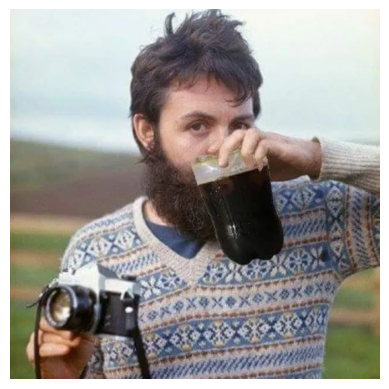

In [28]:
from photoholmes.utils.image import read_image, plot

img = read_image("data/paul.webp")
plot(img)

Detection score: 0.20564976052763073


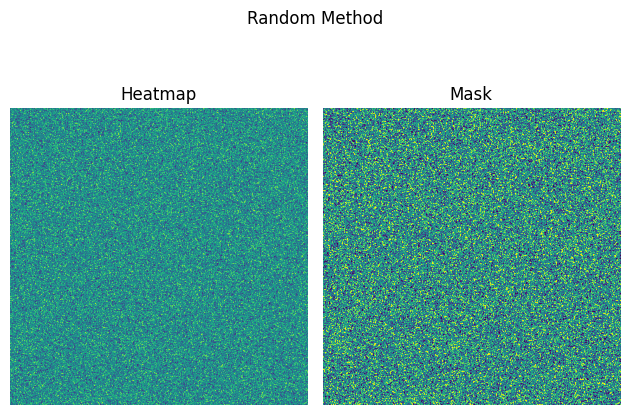

In [30]:
from photoholmes.utils.image import plot_multiple

input_preprocessed = random_method_preprocessing(image=img)
heatmap, mask, score = method.predict(**input_preprocessed)
print("Detection score:", score)
plot_multiple([heatmap, mask], titles=["Heatmap", "Mask"], title="Random Method")

Our method clearly isn't good, but it serves as a good enough example to test the benchmark functionality.

Let's load our datasets and metrics again and run the benchmark.

In [32]:
from photoholmes.datasets.dataset_factory import DatasetFactory, DatasetName
from photoholmes.metrics.factory import MetricFactory, MetricRegistry


columbia_dataset_path: str = (
    "data/Columbia Uncompressed Image Splicing Detection"  # UPDATE WITH THE PATH ON YOUR COMPUTER
)

dataset = DatasetFactory.load(
    DatasetName.COLUMBIA,
    dataset_dir=columbia_dataset_path,
    item_data=["image", "dct_coefficients", "qtables"],
    transform=random_method_preprocessing,
)
print("Total images: ", len(dataset))

metrics = MetricFactory.load([MetricRegistry.AUROC, MetricRegistry.F1, MetricRegistry.IoU])
print(metrics)

Total images:  363
MetricCollection(
  (BinaryAUROC): BinaryAUROC()
  (BinaryF1Score): BinaryF1Score()
  (BinaryJaccardIndex): BinaryJaccardIndex()
)


In [33]:
from photoholmes.benchmark import Benchmark

benchmark = Benchmark(output_folder="example_output")

In [34]:
random_method_results = benchmark.run(method=method, dataset=dataset, metrics=metrics)
print(random_method_results)

INFO - Using device: cpu
INFO - --------------------------------------------------------------------------------
INFO - Running the benchmark
INFO - Benchmark configuration:
INFO -     Method: RandomMethod
INFO -     Dataset: ColumbiaDataset
INFO -     Metrics:
INFO -        - BinaryAUROC
INFO -        - BinaryF1Score
INFO -        - BinaryJaccardIndex
INFO -     Output path: example_output/randommethod/columbiadataset
INFO -     Save method outputs: True
INFO -     Save metrics: True
INFO -     Device: cpu
INFO -     Load existing outputs: True
INFO -     Verbosity: INFO
INFO - --------------------------------------------------------------------------------
Processing Images:   0%|          | 0/363 [00:00<?, ?it/s]WARNING - Image is not in JPEG format. An approximation will be loaded by compressing the image in quality 100.
/home/dsense/extra/tesis/photoholmes/src/photoholmes/datasets/base.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone

If you check the output folder, you will notice a felder _randommethod/columbiadataset_ with the evaluation results.